In [1]:
import torch
import glob
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from tqdm import tqdm
import cv2
import torchvision.models as models
import itertools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Importing the data

In [2]:
glioma_tumors = (glob.glob('/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/*.jpg'))
meningioma_tumors = (glob.glob('/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor/*.jpg'))
no_tumor = (glob.glob("/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/*.jpg"))
pituitary_tumor = (glob.glob("/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor/*.jpg"))

# Plotting the data

(236, 236)


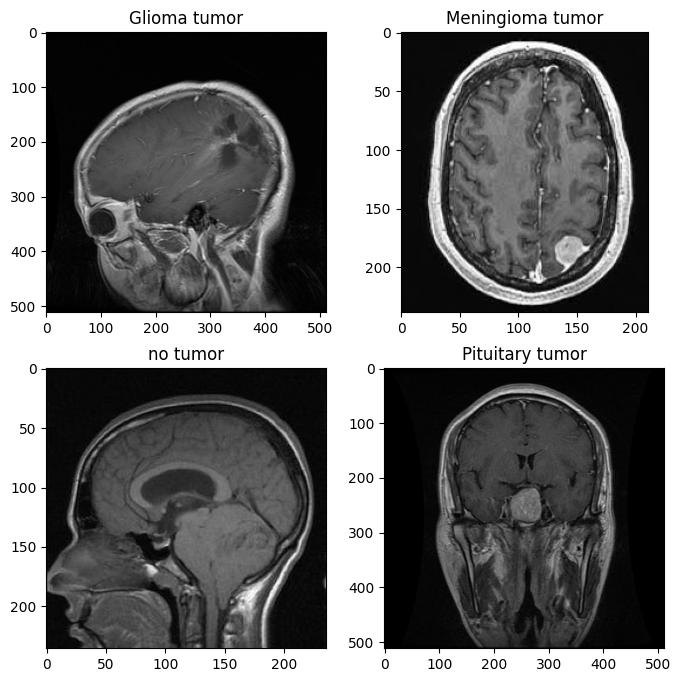

In [3]:
img_path1 = glioma_tumors[0]
img_path2 = meningioma_tumors[0]
img_path3 = no_tumor[0]
img_path4 = pituitary_tumor[0]


plt.figure(figsize = (8,8))
plt.subplot(2,2,1)
img = Image.open(img_path1).convert("RGB")
plt.title("Glioma tumor")
plt.imshow(img)

plt.subplot(2,2,2)
img = Image.open(img_path2).convert("RGB")
plt.title("Meningioma tumor")
plt.imshow(img)

plt.subplot(2,2,3)
img = Image.open(img_path3).convert("RGB")
print(img.size)
plt.title("no tumor")
plt.imshow(img)

plt.subplot(2,2,4)
img = Image.open(img_path4).convert("RGB")
plt.title("Pituitary tumor")
plt.imshow(img)

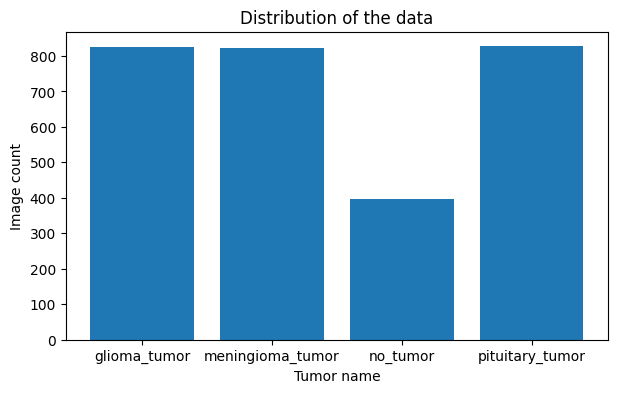

In [4]:
plot_data = {"glioma_tumors": len(glioma_tumors), "meningioma_tumors": len(meningioma_tumors), "no_tumor": len(no_tumor), "pituitary_tumor": len(pituitary_tumor)}
names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
sizes = [len(glioma_tumors), len(meningioma_tumors), len(no_tumor), len(pituitary_tumor)]
figure = plt.figure(figsize = (7,4))
plt.bar(names, sizes)
plt.xlabel("Tumor name")
plt.ylabel("Image count")
plt.title("Distribution of the data")
plt.show()

# Initializing variables

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
running_loss = 0
eval_interval = 25
device
batch_size = 64

# Loading data

In [6]:
X_train = []
y_train = []
image_size = 150
lables_to_index = {"glioma_tumor": 0, "meningioma_tumor": 1, "no_tumor": 2, "pituitary_tumor": 3}
for i in names:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(lables_to_index[i])
        
for i in names:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(lables_to_index[i])
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 72.12it/s]


# Preprocessing Data

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
# Convert numpy arrays to PyTorch tensors
X_train = X_train/255.0
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  

# Create a TensorDataset
dataset = TensorDataset(X_train, y_train)

# Splitting into Training and Testing (80-20 split)

In [8]:
validation_size = int(0.2 * len(dataset))
train_size = len(dataset) - validation_size

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initializing the model

In [9]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.classifier = torch.nn.Linear(model.classifier.in_features, 4)
m = model.to(device)
x, y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)
x = x.to(device)
y = y.to(device)
y_hat = m(x)
print(y.shape)
print(y_hat.shape)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 108MB/s] 


torch.Size([64, 3, 150, 150])
torch.Size([64])
torch.Size([64])
torch.Size([64, 4])


# Defining optimizer and loss function

In [10]:
optimizer = torch.optim.Adam(m.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

# Function to return the loss and accuracy

In [11]:
@torch.no_grad()
def estimate_loss_and_accuracy():
    ys = []
    y_preds = []
    m.eval()
    total_samples = len(val_dataloader)
    losses = torch.zeros(total_samples)
    for i, (x, y) in enumerate(val_dataloader):
        x = x.to(device)
        y = y.to(device)
        y_hat = m(x)
        _, y_pred = torch.max(y_hat, axis = 1)
        ys.extend(y.cpu().numpy())
        y_preds.extend(y_pred.cpu().numpy())
        loss = criterion(y_hat, y) 
        losses[i] = loss.item()
    out = losses.mean()
    correct = (torch.Tensor(y_preds) == torch.Tensor(ys)).sum().item()
    accuracy = correct/len(ys)
    m.train()
    return out, accuracy

In [12]:
@torch.no_grad()
def accuracy(y_pred, y_true):
    m.eval()
    _, predicted = torch.max(y_pred, dim = 1)
    correct = (predicted == y_true).sum().item()
    total = y_true.size(0)
    m.train()
    return correct / total

# Training loop

In [13]:
train_losses = []
val_losses = []
train_accuracies = torch.zeros(len(train_dataloader))
final_train_accuracies = []
final_val_accuracies = []
for n in range(epochs):
    print(f"Epoch {n}")
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        
        y_hat = m(x)
        loss = criterion(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        train_accuracies[i] = accuracy(y_hat, y)
        
    val_loss, val_accuracy = estimate_loss_and_accuracy()
    mean_loss = running_loss/len(train_dataloader)
    train_acc = train_accuracies.mean()
    final_train_accuracies.append(train_acc.item())
    final_val_accuracies.append(val_accuracy)
    train_losses.append(mean_loss)
    val_losses.append(val_loss)

    print(f"Step {i}: Train loss = {mean_loss:.4f}, Val loss = {val_loss:.4f}, Train Accuracy = {train_acc:.2f}, Val Accuracy = {val_accuracy:.2f}")
    running_loss = 0
    train_accuracies = torch.zeros(len(train_dataloader))


Epoch 0
Step 40: Train loss = 0.6115, Val loss = 0.4661, Train Accuracy = 0.78, Val Accuracy = 0.82
Epoch 1
Step 40: Train loss = 0.1304, Val loss = 0.1876, Train Accuracy = 0.96, Val Accuracy = 0.93
Epoch 2
Step 40: Train loss = 0.0395, Val loss = 0.1688, Train Accuracy = 1.00, Val Accuracy = 0.95
Epoch 3
Step 40: Train loss = 0.0173, Val loss = 0.1598, Train Accuracy = 1.00, Val Accuracy = 0.95
Epoch 4
Step 40: Train loss = 0.0091, Val loss = 0.1630, Train Accuracy = 1.00, Val Accuracy = 0.95
Epoch 5
Step 40: Train loss = 0.0054, Val loss = 0.1807, Train Accuracy = 1.00, Val Accuracy = 0.95
Epoch 6
Step 40: Train loss = 0.0045, Val loss = 0.1532, Train Accuracy = 1.00, Val Accuracy = 0.95
Epoch 7
Step 40: Train loss = 0.0054, Val loss = 0.1480, Train Accuracy = 1.00, Val Accuracy = 0.95
Epoch 8
Step 40: Train loss = 0.0039, Val loss = 0.1452, Train Accuracy = 1.00, Val Accuracy = 0.96
Epoch 9
Step 40: Train loss = 0.0040, Val loss = 0.1760, Train Accuracy = 1.00, Val Accuracy = 0.96


# Plotting learning curves

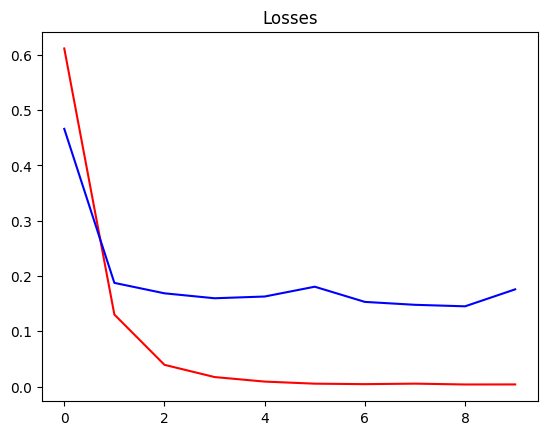

In [14]:
plt.title("Losses")
plt.plot(range(epochs), train_losses, color = "red")
plt.plot(range(epochs), val_losses, color = "blue")
plt.show()

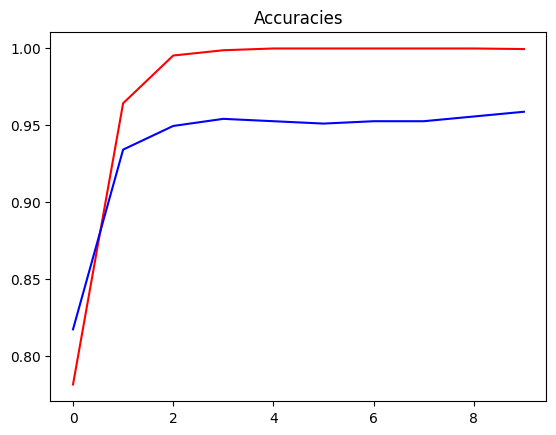

In [15]:
plt.title("Accuracies")
plt.plot(range(epochs), final_train_accuracies, color = "red")
plt.plot(range(epochs), final_val_accuracies, color = "blue")
plt.show()

# Displaying results and metrics

In [16]:
ys = []
y_preds = []
print(len(val_dataloader))
m.eval()
for x, y in val_dataloader:
    ys.extend(y)
    y_hats = m(x.to(device))
    _, y_pred = torch.max(y_hats, axis = 1)
    y_preds.extend(y_pred.cpu().numpy())
m.train()
print(len(ys))
print(len(y_preds))
ys = ys
y_preds = y_preds

11
652
652


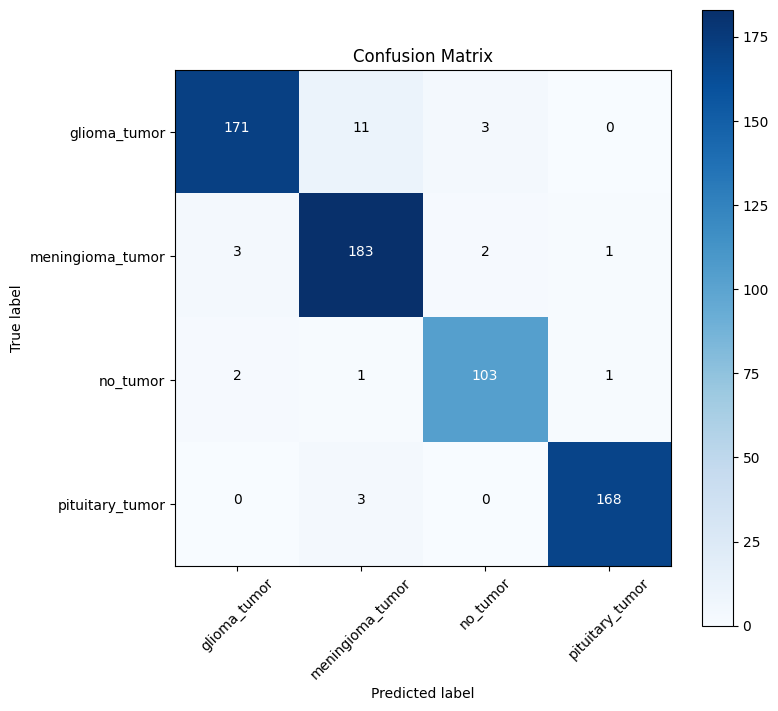

In [17]:
# Plot confusion matrix
cm = confusion_matrix(ys, y_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names, rotation=45)
plt.yticks(tick_marks, names)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
# Accuracy
print(len(y_train))
correct = (torch.Tensor(y_preds) == torch.Tensor(ys)).sum().item()
total = len(ys)
print(correct / total)

3264
0.9585889570552147


In [19]:
report = classification_report(ys, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       185
           1       0.92      0.97      0.95       189
           2       0.95      0.96      0.96       107
           3       0.99      0.98      0.99       171

    accuracy                           0.96       652
   macro avg       0.96      0.96      0.96       652
weighted avg       0.96      0.96      0.96       652



# Saving and Loading Model

In [20]:
# torch.save(m.state_dict(), 'efficientDenseNet.pth')
# m = model.to(device)
# gen_opt = torch.optim.Adam(m.parameters())
# m.load_state_dict(torch.load('/kaggle/working/m_100.pth'))

# Thank you!